In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Mounted at /content/gdrive/


In [2]:
!pip install -U -q git+https://github.com/sparsh-ai/recochef.git


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
%cd gdrive
%cd MyDrive
%cd Colab Notebooks
%cd Rec_final
%cd du
!ls

/content/gdrive
/content/gdrive/MyDrive
/content/gdrive/MyDrive/Colab Notebooks
/content/gdrive/MyDrive/Colab Notebooks/Rec_final
/content/gdrive/MyDrive/Colab Notebooks/Rec_final/du
'Copy of yahoo_movie_user-Copy1.ipynb'
 kjj
 Model.py
 pre_process.py
 __pycache__
 README.md
 reduce_size_df.py
 run_model.py
 Train_fn.py
 yahoo_movie_user-Copy1.ipynb
 ydata-ymovies-user-movie-ratings-test-v1_0.txt.gz
 ydata-ymovies-user-movie-ratings-train-v1_0.txt.gz


In [3]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler

from recochef.utils.iterators import batch_generator

import math
import copy
import pickle
import numpy as np
import pandas as pd
from textwrap import wrap
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm import tqdm
import time
from reduce_size_df import reduce_mem_usage
from pre_process import _preprocess_data
from Train_fn import train,validation
from Model import MLP
from run_model import run_epochs

In [4]:
df=pd.read_csv(r'ydata-ymovies-user-movie-ratings-train-v1_0.txt.gz',sep='\t',compression='gzip',encoding='latin-1',header=None)
df_test=pd.read_csv(r'ydata-ymovies-user-movie-ratings-test-v1_0.txt.gz',sep='\t',compression='gzip',encoding='latin-1',header=None)
df=reduce_mem_usage(df)
df_test=reduce_mem_usage(df_test)
df.rename(columns={0: 'u_id', 1: 'i_id',3:'rating'},inplace=True)
df_test.rename(columns={0: 'u_id', 1: 'i_id',3:'rating'},inplace=True)
df_test.drop(2,axis='columns',inplace=True)
df.drop(2,axis='columns',inplace=True)

Memory usage of dataframe is 6.45 MB
Memory usage after optimization is: 1.61 MB
Decreased by 75.0%
Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.08 MB
Decreased by 75.0%


In [5]:
ratings_df,user_map,item_map=_preprocess_data(df)
df_test['u_id']=df_test['u_id'].map(user_map)
df_test['i_id']=df_test['i_id'].map(item_map)


In [11]:
trainloss,valloss=run_epochs(features=1,hidden_sz=100,learning_rate=0.001,batch=256,epochs=100,patience=1,
                             model_fn=MLP,training_data=ratings_df,testing_data=df_test)

Iteration: 1 ;train_MSE =2.1923 ;  val_MSE = 1.2354 ; time=3.9878
Iteration: 2 ;train_MSE =1.3084 ;  val_MSE = 1.1207 ; time=3.4401
Iteration: 3 ;train_MSE =1.1993 ;  val_MSE = 1.0595 ; time=3.3270
Iteration: 4 ;train_MSE =1.1211 ;  val_MSE = 1.0275 ; time=3.4259
Iteration: 5 ;train_MSE =1.0586 ;  val_MSE = 0.9901 ; time=3.4970
Iteration: 6 ;train_MSE =1.0100 ;  val_MSE = 0.9793 ; time=3.4588
Iteration: 7 ;train_MSE =0.9724 ;  val_MSE = 0.9754 ; time=3.4354
Iteration: 8 ;train_MSE =0.9434 ;  val_MSE = 0.9558 ; time=3.4250
Iteration: 9 ;train_MSE =0.9209 ;  val_MSE = 0.9539 ; time=3.5011
Iteration: 10 ;train_MSE =0.9022 ;  val_MSE = 0.9544 ; time=3.4463


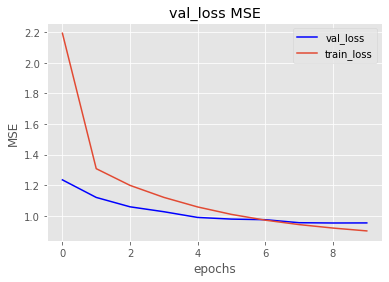

In [12]:
#plt.plot(trainloss)
plt.plot(valloss,color='blue',label='val_loss')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('val_loss MSE')
plt.plot(trainloss,label='train_loss')
plt.legend()

git: 'mkdir' is not a git command. See 'git --help'.


In [ ]:
n_epochs=10
bs=64
epoch_loss=0
for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        for batch in batch_generator(*datasets[phase], shuffle=training, bs=bs):
            x_batch, rating = [b for b in batch]
            with torch.set_grad_enabled(training):
                optimizer.zero_grad()
                prediction = model(x_batch[:, 0], x_batch[:, 1])
                loss = loss_fn(prediction, rating)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    loss.backward()
                    optimizer.step()
            running_loss+=loss.item()
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))


[001/010] train: 1.7992 - val: 1.1081
[002/010] train: 1.2022 - val: 1.0245
[003/010] train: 1.0851 - val: 0.9954
[004/010] train: 1.0102 - val: 0.9740
[005/010] train: 0.9629 - val: 0.9624
[006/010] train: 0.9317 - val: 0.9634
[007/010] train: 0.9086 - val: 0.9570
[008/010] train: 0.8906 - val: 0.9651
[009/010] train: 0.8745 - val: 0.9770
[010/010] train: 0.8607 - val: 0.9691


In [ ]:
minmax = ratings_df.rating.astype(float).min(), ratings_df.rating.astype(float).max()
minmax

(1.0, 5.0)

In [ ]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [ ]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
            
        return base_lr + delta
        
    return scheduler
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

In [ ]:
n_users = ratings_df.u_id.nunique()
n_movies = ratings_df.i_id.nunique()
net = EmbeddingNet(
    n_users=n_users, n_items=n_movies, 
    n_factors=150, hidden=[500, 500, 500], 
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

In [ ]:
lr = 1e-3
wd = 1e-5
bs = 50
n_epochs = 100
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        
        for batch in batch_generator(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
        
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

        
        

loss improvement on epoch: 1
[001/100] train: 1.3315 - val: 1.2745
loss improvement on epoch: 2
[002/100] train: 1.1957 - val: 1.2590
[003/100] train: 1.2221 - val: 1.2639


KeyboardInterrupt: ignored

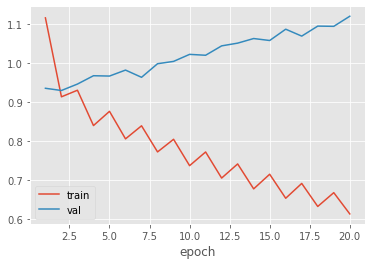

In [ ]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')
